<a href="https://colab.research.google.com/github/gytj2013/NewPhago/blob/main/newphago_summarize.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!curl -s https://raw.githubusercontent.com/teddylee777/machine-learning/master/99-Misc/01-Colab/mecab-colab.sh | bash

In [ ]:
!pip install konlpy
!pip install git+https://github.com/kakaobrain/pororo.git
!pip install pykrx 
!pip install jamo

In [ ]:
! git clone https://github.com/SOMJANG/Mecab-ko-for-Google-Colab.git

In [ ]:
cd Mecab-ko-for-Google-Colab

In [ ]:
#!bash install_mecab-ko_on_colab_light_220111.sh
!bash install_mecab-ko_on_colab_light_220429.sh

In [6]:
from pororo import Pororo

In [ ]:
cd ../

In [ ]:
!pip install -U Finance-DataReader

In [9]:
# 코스피 코스닥 상장 기업 정보 리스트 생성
from pykrx import stock
import pandas as pd
import FinanceDataReader as fdr
import matplotlib.pyplot as plt
import platform
from datetime import datetime, timedelta

today = datetime.today().strftime("%Y%m%d")
last_week = (datetime.today() - timedelta(7)).strftime("%Y%m%d")

KOSDAQ = stock.get_market_ticker_list(market="KOSDAQ")
KOSPI = stock.get_market_ticker_list(market="KOSPI")

def return_name():
    Company = []

    for ticker in KOSDAQ:
        Value =stock.get_market_ticker_name(ticker)
        Company.append([Value,ticker,"KOSDAQ"]) # 기업명, 종목번호, 코스닥 리스트에 추가
      
    for ticker in KOSPI:
        Value =stock.get_market_ticker_name(ticker)
        Company.append([Value,ticker,"KOSPI"]) # 기업명, 종목번호, 코스닥 리스트에 추가
 
    return Company;

No Korean fonts found. Please install the font shown belowbecause Hangul can be broken on the chart.
 - NanumBarunGothic font is required.

    1) font install

    !sudo apt-get install -y fonts-nanum
    !sudo fc-cache -fv
    !rm ~/.cache/matplotlib -rf

    2) runtime restart if colab
    
PYKRX works fine regardless of font installation.


In [10]:
# 종성 여부 체크
from jamo import h2j, j2hcj

def get_jongsung_TF(text):
  sample_text_list = list(text)
  last_word = sample_text_list[-1]
  last_word_jamo_list = list(j2hcj(h2j(last_word)))
  last_jamo = last_word_jamo_list[-1]

  jongsung_TF = "T"

  if last_jamo in ['ㅏ','ㅑ','ㅓ','ㅕ','ㅗ','ㅛ','ㅜ','ㅠ','ㅡ','ㅣ','ㅘ','ㅚ','ㅙ','ㅝ','ㅞ','ㅢ','ㅐ','ㅔ','ㅟ','ㅖ','ㅒ'] :
    jongsung_TF = "F"

  return jongsung_TF

In [11]:
# 사용자 사전 적용 : 고유명사 구분하기 위해 코스피, 코스닥 상장 기업들 사용자 사전에 추가
with open("./mecab-ko-dic-2.1.1-20180720/user-dic/nnp.csv",'r',encoding='utf-8') as f:
  file_data = f.readlines()
Company = return_name()
for c in Company:
  jongsung_TF = get_jongsung_TF(c[0])
  line = '{},,,,NNP,*,{},{},*,*,*,*,*\n'.format(c[0], jongsung_TF, c[0])
  file_data.append(line)
with open("./mecab-ko-dic-2.1.1-20180720/user-dic/nnp.csv",'w',encoding='utf-8') as f:
  for line in file_data:
    f.write(line)

In [12]:
# 뉴스 요약 및 기업 정보 추출
from bs4 import BeautifulSoup
import requests
from nltk.corpus import stopwords 
from nltk.tokenize import word_tokenize
from konlpy.tag import Mecab
from pykrx import stock
import pandas as pd
import FinanceDataReader as fdr
import matplotlib.pyplot as plt
import platform
from datetime import datetime, timedelta

today = datetime.today().strftime("%Y%m%d")
last_week = (datetime.today() - timedelta(7)).strftime("%Y%m%d")

bullet_summ = Pororo(task="text_summarization", lang="ko", model="bullet")
abs_summ = Pororo(task="text_summarization", lang="ko", model="abstractive")
# 감성 분석
stock_feel=Pororo(task='sentiment', model='brainbert.base.ko.nsmc', lang='ko')

def summerize_news(url, Company):
    headers = {"User-Agent": "Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/87.0.4280.88 Safari/537.36"}
    req = requests.get(url, headers=headers)
    soup = BeautifulSoup(req.text, 'html.parser')
    body = soup.find_all(id='dic_area')
    if len(body) > 0:
        text = body[0].text
        output_bullet = bullet_summ(text,
                                    beam=5,
                                    len_penalty=0.6,
                                    no_repeat_ngram_size=3,
                                    top_k=50,
                                    top_p=0.7)
        summary_output = abs_summ(text,
                                  beam=5,
                                  len_penalty=0.6,
                                  no_repeat_ngram_size=3,
                                  top_k=50,
                                  top_p=0.7
                                  )
      
        mecab = Mecab()
        noun = mecab.nouns(summary_output) # 명사만 추출
        pos = mecab.pos(summary_output) # 형태소 분석
        removelist = ['JKS', 'JKC', 'JKG', 'JKO', 'JKB', 'JKV', 'JKQ', 'JX', 'JC', 'EF'] # 조사 품사 리스트 - 제거할 품사
        resultlist = []
        for p in pos :
          if len(p[0])>1 and p[1] not in removelist : # 토큰의 길이가 1 초과이고 조사가 아니면 감정 분석에 활용할 토큰이므로 리스트에 추가
            resultlist.append(p)
        #print(pos)
        #print(resultlist)

        company_name = []
        for c in Company :
          company_name.append(c[0]);

        summ = "[주요] \n"
        for line in output_bullet:
          summ += "-"+line+"\n"
        summ += "[요약] \n"
        summ += summary_output+"\n" # 뉴스 요약본
        summ += "[회사정보] \n"
        chk = False
        idx = 0
        for n in noun : # 뉴스 요약본 속 명사들 중에서 코스피, 코스닥 상장 기업명 찾기
          try :
            idx = company_name.index(n)
          except :
            chk = False
          else :
            summ += str(Company[idx])
            chk = True
            break
        if chk==False :
          summ += "null \n"
        feel_res=stock_feel(summary_output)
        print(feel_res)
        print(summ)
        if (idx != 0):
          ticker = Company[idx][1]
          info_a = stock.get_market_ohlcv(last_week, today, ticker)
          print(info_a) #주가
          info_b = stock.get_market_cap(last_week, today, ticker)
          print(info_b) #시가총액, 거래량, 거래대금, 상장주식수 
          info_c = stock.get_exhaustion_rates_of_foreign_investment(last_week, today, ticker)
          print(info_c) #외국인 보유량 및 외국인 한도소진율
          info_d = stock.get_market_fundamental(last_week, today, ticker)
          print(info_d) #DIV/BPS/PER/EPS
          info_e = stock.get_shorting_volume_by_date(last_week, today, ticker)
          print(info_e) #공매도 현황
          info_g = fdr.DataReader(symbol=ticker, start= "2020")
          fig = plt.figure(figsize=(14, 6))
          ax = fig.add_subplot(1, 1, 1)
          ax.plot(info_g['Close'])
          ax.set_xlabel("Date")
          ax.set_ylabel(ticker)
          ax.set_title("stock price")
          plt.grid(True, axis='y')
          plt.show() #주가그래프
        return summ
    else:
        print("error")
        return "error"

Downloading:   0%|          | 0.00/1.35k [00:00<?, ?B/s]

You passed along `num_labels=3` with an incompatible id to label map: {'0': 'NEGATIVE', '1': 'POSITIVE'}. The number of labels wil be overwritten to 2.


Downloading:   0%|          | 0.00/337 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.00M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/110 [00:00<?, ?B/s]




You passed along `num_labels=3` with an incompatible id to label map: {'0': 'NEGATIVE', '1': 'POSITIVE'}. The number of labels wil be overwritten to 2.



[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[Korean Sentence Splitter]: Initializing Pynori...


Negative
[주요] 
-탈모 예방에 도움...탈모 예방에도 도움
- 체중 감량을 목표로 하는 사람이라면 오이에 대해 다시 한번 생각하는 것도 좋을 듯
[요약] 
몸매가루나 소금을 넣어 요리할 때 오이를 조금만 먹어도 비타민C가 파괴되어 숙취 해소에 도움이 되므로 오이를 넣은 물이 디톡스 효과는 물론 피부에 도움이 된다고 한다.
[회사정보] 
null 

Positive
[주요] 
-4월 소비자물가 4.8%↑
- 기대 인플레이션율 3.1%
[요약] 
우리나라는가루, 계란, 식용유 등이 올라가고 있는 현실을 반영해 앞으로는 더 오를 것이라는 불안 심리가 퍼져 있다고 밝혔다.
[회사정보] 
null 

Positive
[주요] 
-文대통령, 조국 법무장관 임명 후 첫 공식일정
- 靑 "윤석열 검찰총장 임명...검찰개혁 속도낼 것"
[요약] 
조국 전 법무부 장관은 16일 자신의 이야기를 다룬 영화 '그대가 조국' 펀딩 결과에 놀라워하며 "열화와 같은 성원에 감동했다"고 말했다.
[회사정보] 
null 

Positive
[주요] 
-스테이블코인 '기축통화' 역할
- 루나 사태로 시장 전체 위기 우려
[요약] 
미국은 규제를 통해 스테이블코인의 위험성을 보여주는 루나 사태에 대비하여 가상자산 규제 강화를 더욱 앞당길 것으로 보인다.
[회사정보] 
null 

Negative
[주요] 
-"文대통령, 국민께 송구...국민께 사과해야"
- "文정권 폭정 막아야"
[요약] 
다녀명 더불어민주당 계양을 후보가 벤치에 신발을 신고 올라가는 모습을 보며 여야가 몰상식을 놓고 논쟁을 펼쳤다.
[회사정보] 
null 

Positive
[주요] 
-文대통령, 16일 국무회의 주재
- 文, 국무회의 모두발언
[요약] 
6·1 지방선거의 최대 격전지로 꼽히는 경기지사 선거에서 김동연 더불어민주당 후보와 김은혜 국민의힘 후보가 오차범위 내 접전을 벌이는 것으로 나타나 주목된다.
[회사정보] 
null 

Positive
[주요] 
-文대통령, 日 경제보복에 "수출규제 철회하라"
-

[Korean Sentence Splitter]: findfont: Font family ['Malgun Gothic'] not found. Falling back to DejaVu Sans.
[Korean Sentence Splitter]: findfont: Font family ['Malgun Gothic'] not found. Falling back to DejaVu Sans.


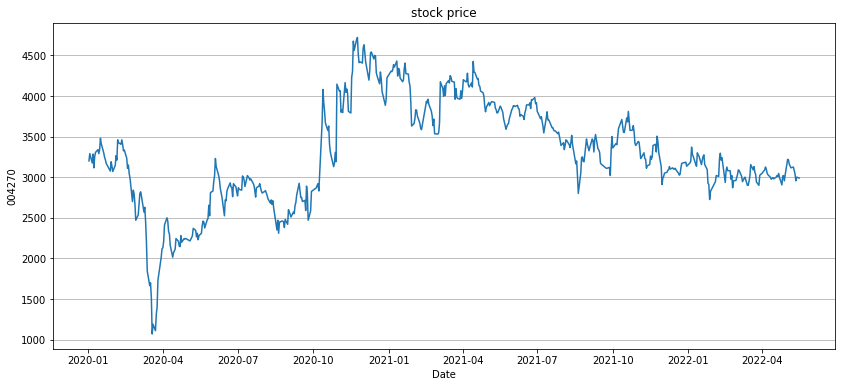

Positive
[주요] 
-文대통령, 코로나19 대응 관계장관회의 주재
- 文 "코로나 대응, 비상한 각오로 임해달라"
[요약] 
'국회의원'을 지낸 이력이 없는 '0선 신인' 윤석열 대통령이 첫 시정연설로 국회무대 데뷔를 한 가운데 허리를 숙이며 인사하는 모습이 포착되어 경직된 분위기가 누그러졌다.
[회사정보] 
null 

Positive
[주요] 
-민주당, 코로나19 관련 긴급 당정청 대책회의 개최
- "코로나 대응에 총력"
[요약] 
16일석열 대통령이 국회 시정연설에서 지난 2년간 코로나 방역 조치에 협조하는 과정에서 소상공인을 중심으로 막대한 피해가 발생했다며, 손실보상 보전금을 지원하는 등 민생 안정을 위한 지원을 하겠다고 밝혔다.
[회사정보] 
null 

Negative
[주요] 
-文대통령, 16일 국무회의서 日 수출규제 대응 방안 논의
- 日, 韓 수출규제 조치 철회 촉구
[요약] 
이재명 전 지사는 16일 부인 김혜경 씨의 법인카드 유용 의혹이 국고손실죄로 고발된 데 대해 "공석인 자리에 공무를 통해 뽑힌 공무원이 사적인 지원을 몇 차례 했다고 공무원이 공무를 하는 사람인데 어떻게 국고손실을 될 수 있냐"고 반박했다.
[회사정보] 
null 

Negative
[주요] 
-1분기 매출 93억, 영업이익 15억
- 전년 동기 대비 매출 8%, 영업이익 121% 증가
[요약] 
아톤이 모바일 일회용비밀번호(OTP)와 마이데이터 사업 등 영업이익율이 높은 금융권의 보안·인증 실적이 두드러지면서 1분기 연결기준 매출액 93억원, 영업이익 15억원을 기록했다고 16일 공시했다.
[회사정보] 
['아톤', '158430', 'KOSDAQ']
               시가     고가     저가     종가    거래량
날짜                                           
2022-05-09  30700  31400  29800  30000  31171
2022-05-10  29100  30000  28400  29

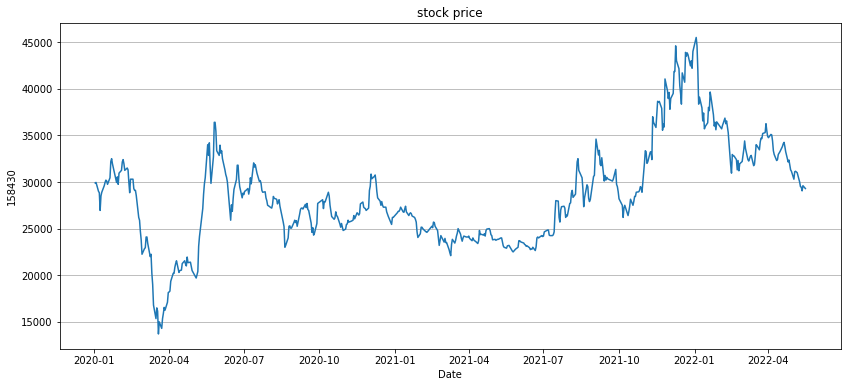

Negative
[주요] 
-SK이노베이션 배터리 자회사
- 직원 만족도 높아
[요약] 
지난해 10월 SK이노베이션의 배터리 자회사 SK온이 직장인들 사이에서 주목을 받으면서 화제를 모으고 있다.
[회사정보] 
null 

Negative
[주요] 
-文대통령, 日 수출규제 대응 관계장관회의 주재
- 日, 韓수출규제 조치 철회 촉구
[요약] 
통일정부는 신종 코로나바이러스 감염증(코로나19) 방역·보건 지원을 하겠다는 내용을 담은 통지문 전달을 시도했으나, 북측이 아직 통지문의 접수 의사를 밝히고 있지 않아 통일부장관 명의의 대북통지문을 김영철 통일전선부 부장에게 보내려 했으나 아직 접수 의사를 밝히지 않았다.
[회사정보] 
null 

Negative
[주요] 
-국립공원 7개 대피소 오늘부터 점진적 개방
- 지리산 장터목, 세석 벽소령, 벽소령은 연하천, 설악산 중청, 소백산 제2연화봉대피소
[요약] 
커플로 문을 닫았던 국립공원 대피소가 오늘부터 점진적으로 개방되는데 대피소 예약 시 감염병 예방 준수사항에 동의해야 하며 대피소 숙박은 국립공원예약시스템(reservation.knps.or.kr)을 통해 선착순으로 예약할 수 있다.
[회사정보] 
null 

Negative
[주요] 
-文대통령, 취임 후 첫 국무회의 주재
- 文 "북미회담 성공적 개최 기원"
[요약] 
이준석 국민의힘 대표가 인천 계양을 보궐 선거에 나선 이재명 더불어민주당 후보의 짧은 영상을 공개하며 '이는 신발을 벗고 올라가야 한다'를 강조하는 가운데 김은혜 국민의힘 경기지사 후보의 신발을 신고 벤치 위로 올라간 사진으로 맞불을 놓기도 했다.
[회사정보] 
null 

Positive
[주요] 
-文대통령, 국무회의서 日 수출규제 대응방안 논의
- 日, 韓 수출규제 조치 철회 요구...韓, 수출규제 철회 촉구
[요약] 
내년 위원장은 병장 월급이 100만원으로 인상된다고 발표했는데, 이는 인수위원회가 지난 3일 국정과제를 선정하면서 '병사봉급+자산형성 프로그램'으로 월 200만원을 지

'\n# mount it\nfrom google.colab import drive\ndrive.mount(\'/content/drive\')\n# copy it there\n!cp "20220408_summarized.txt" /content/drive/MyDrive\n!cp "20220408_url.txt" /content/drive/MyDrive\n'

In [13]:
import time
import re
import requests
from datetime import datetime
from dateutil.relativedelta import relativedelta

# 오늘 날짜 형식화
now=datetime.now()
now=str(now)
year=now[0:4]
month=now[5:7]
day=now[8:10]
res=year+month+day

# url file에 저장 (max_page_num 바꿔주면 됨)
output_file_name=str(res)+"_url.txt"
output_file = open(output_file_name, "w", encoding="utf-8")
page_num = 1
max_page_num = 1

user_agent = "'Mozilla/5.0"
headers ={"User-Agent" : user_agent}

urls = []
while page_num<=max_page_num:
    page_url = "http://news.naver.com/main/list.nhn?sid2=258&sid1=101&mid=shm&mode=LS2D&date=" + str(res) + "&page=" + str(page_num) + ""
    response = requests.get(page_url, headers=headers)
    html = response.text
    # url 추출
    url_frags = re.findall('<a href="(.*?)"',html)
    for url_frag in url_frags:
        if "article" in url_frag:
            urls.append(url_frag)
            #print(url_frag)
    page_num+=1
urls=set(urls)
for url in urls:
    print(url, file=output_file)
time.sleep(2)
output_file.close()

# url 바탕으로 요약문 생성
# 요약문 file에 저장(테스트용으로 count로 6개만 끊어준것임)
output_file_name2=str(res)+"_summarized.txt"
output_file2 = open(output_file_name2, "w", encoding="utf-8")
count=0
for url in urls:
  if(count>20):
    break
  count=count+1
  print(summerize_news(url,return_name()), file=output_file2)
output_file2.close()
'''
# mount it
from google.colab import drive
drive.mount('/content/drive')
# copy it there
!cp "20220408_summarized.txt" /content/drive/MyDrive
!cp "20220408_url.txt" /content/drive/MyDrive
'''


In [ ]:
#summerize_news('https://n.news.naver.com/mnews/article/277/0005088162?sid=101', return_name())